In [1]:
%matplotlib inline
import numpy as np
import pylab
import pytry
import pandas
import seaborn
from nengo_bee import NengoBee

In [2]:
data = pytry.read('gather_pif_update_11_17')

In [5]:
bee = NengoBee()

all_x = np.vstack([d['x'][:] for d in data])
all_x_body = bee.bee.world_state_to_body(all_x)
all_u = np.vstack([d['u'][:] for d in data])
# all_du = np.vstack([d['u_dot'][0:4] for d in data])
# all_du = np.vstack([np.diff(d['u'], axis=0) for d in data])/0.001

mean_x = np.mean(all_x, axis=0)
mean_x_body = np.mean(all_x_body, axis=0)
mean_u = np.mean(all_u, axis=0)
# mean_du = np.mean(all_du, axis=0)
std_x = np.std(all_x, axis=0)
std_x_body = np.std(all_x_body, axis=0)
std_u = np.std(all_u, axis=0)
# std_du = np.std(all_du, axis=0)

print(mean_x_body)
print(mean_u)
# print(mean_du)

C:\Anaconda3\lib\site-packages\scipy\integrate\_ode.py:1035: UserWarning: dopri5: step size becomes too small
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


[ -3.34077715e-03   5.20887476e-03   8.19924744e-01  -4.50164785e+00   3.34082902e-03  -5.29115107e-03  -8.20093299e-01   4.50656742e+00   8.50250013e-02   3.80278145e-03  -7.86870285e-02  -1.74997696e-03   3.63086332e-04   1.73784613e-02   9.48884541e-01  -6.12793808e-02  -1.30860398e+00  -5.39731262e-02  -2.24585886e-03   9.05146106e-02]
[  1.29123365e+02   2.80558686e+00   2.22613165e+07  -9.65340126e-04]


In [6]:
x_names = [
    '$\phi_r$',
    '$\psi_r$',
    '$\dot{\phi}_r$',
    '$\dot{\psi}_r$',
    '$\phi_l$',
    '$\psi_l$',
    '$\dot{\phi}_l$',
    '$\dot{\psi}_l$',
    '$\phi$',
    '$\\theta$',
    '$\psi$',
    '$x$',
    '$y$',
    '$z$',
    '$\dot{\phi}$',
    '$\dot{\\theta}$',
    '$\dot{\psi}$',
    '$\dot{x}$',
    '$\dot{y}$',
    '$\dot{z}$',
]

u_names = [
    'stroke ampl.', 'pitch torque', 'yaw torque', 'roll'
]

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


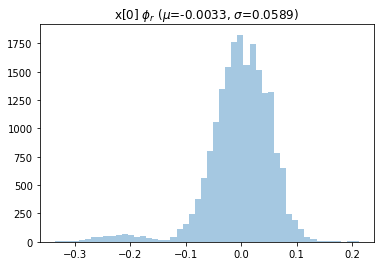

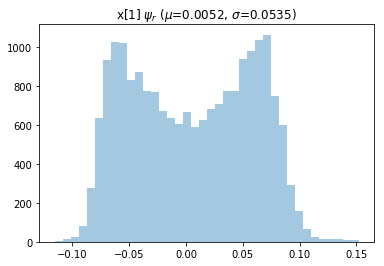

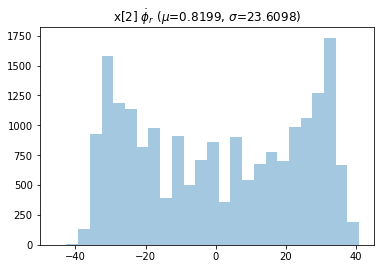

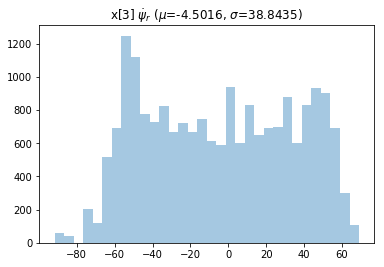

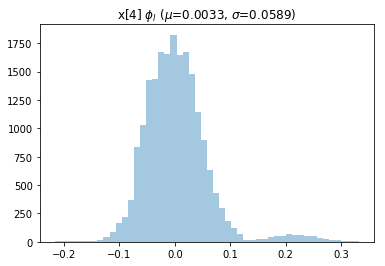

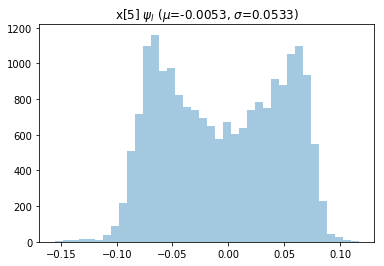

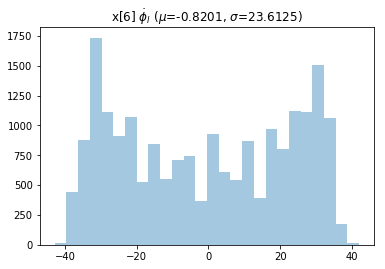

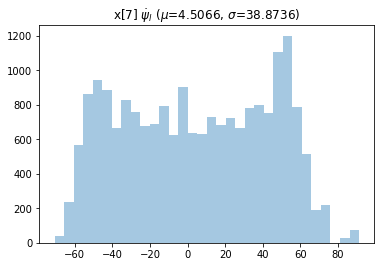

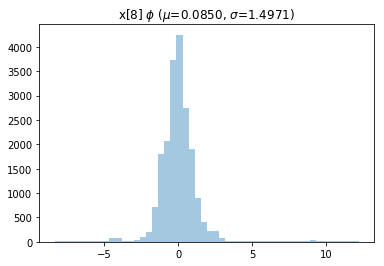

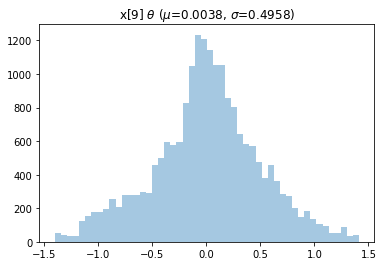

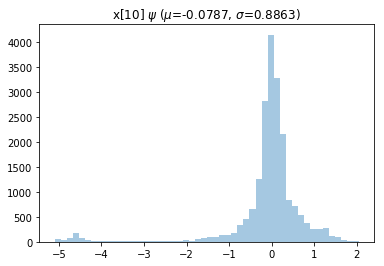

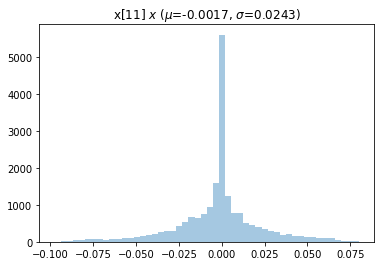

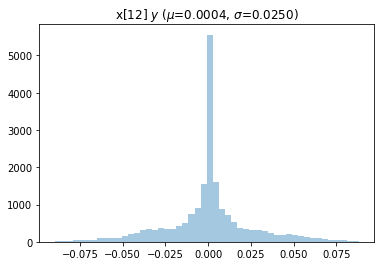

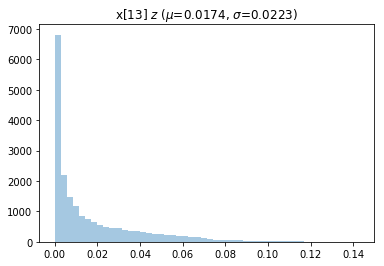

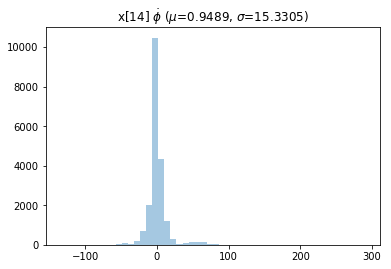

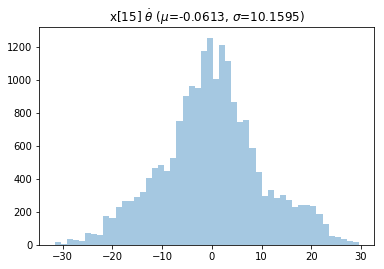

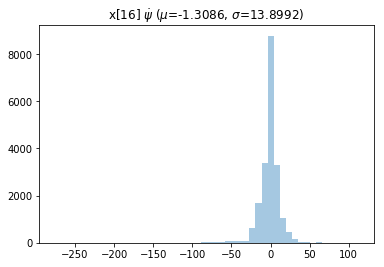

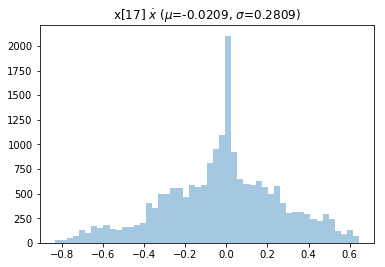

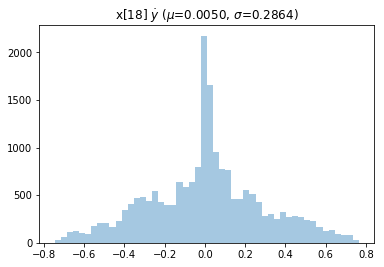

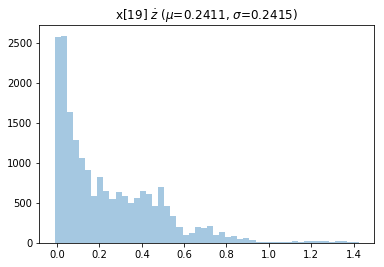

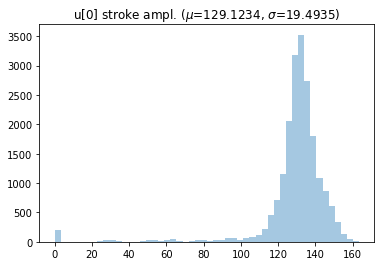

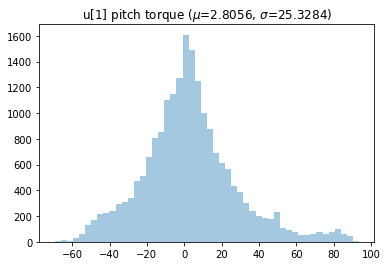

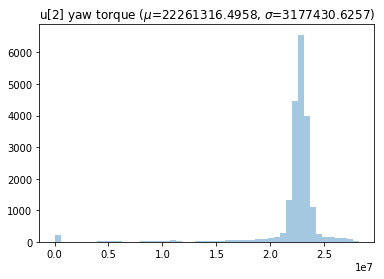

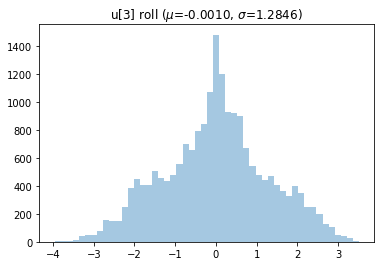

In [8]:
for i in range(20):
    pylab.figure()
    seaborn.distplot(all_x[:,i], kde=0)
    pylab.title('x[%d] %s ($\mu$=%1.4f, $\sigma$=%1.4f)' % (i, x_names[i], mean_x[i], std_x[i]))
    
for i in range(4):
    pylab.figure()
    if std_u[i] > 0:
        seaborn.distplot(all_u[:,i], kde=0)
    pylab.title('u[%d] %s ($\mu$=%1.4f, $\sigma$=%1.4f)' % (i, u_names[i], mean_u[i], std_u[i]))
    
# for i in range(4):
#     pylab.figure()
#     if std_u[i] > 0:
#         seaborn.distplot(all_du[:,i], kde=0)
#     pylab.title('$\dot{u}$[%d] %s rate ($\mu$=%1.4f, $\sigma$=%1.4f)' % (i, u_names[i], mean_du[i], std_du[i]))

In [9]:
norm_x = (all_x - mean_x) / std_x
norm_x_body = (all_x_body - mean_x_body) / std_x_body
norm_u = (all_u - mean_u) / std_u
# norm_du = (all_du - mean_du) / std_du

In [11]:
keep_x_names = ['theta_dot', 'psi_dot', 'v_x', 'v_y', 'v_z']
keep_x = [bee.bee.state_names.index(name) for name in keep_x_names]
keep_u = [1,3]

x_vals = norm_x[:,keep_x]
u_vals = norm_u[:,keep_u]

# du_vals = norm_du[:,[0,1,3]]
pts = np.hstack([x_vals, u_vals])

print(np.shape(pts))

(20000, 7)


In [13]:
import nengo
model = nengo.Network()
with model:
    D = pts.shape[1]
    ens = nengo.Ensemble(n_neurons=500, dimensions=D, neuron_type=nengo.LIFRate(), radius=np.sqrt(D))
    u_node = nengo.Node(None, size_in=3)
    
    c = nengo.Connection(ens, u_node, eval_points=pts, scale_eval_points=False, function=u_vals)

ValidationError: Connection.function: function output size is incorrect; should return a vector of size 3

In [21]:
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [22]:
sim.data[c].solver_info

{'rmses': array([ 0.34362514,  0.14823852,  0.13578992]),
 'time': 0.35450029373168945}

In [23]:
pylab.plot(fn)

NameError: name 'fn' is not defined

In [14]:
np.savez('gather-hover_11_17', 
         mean_x=mean_x,
         mean_x_body=mean_x_body,
         mean_u=mean_u, 
         std_x=std_x,
         std_x_body=std_x_body,
         std_u=std_u,
#          mean_du=mean_du,
#          std_du=std_du, 
#          all_du=all_du,
         all_u=all_u,
         all_x=all_x,
         all_x_body=all_x_body,
         norm_x=norm_x,
         norm_x_body=norm_x_body,
         norm_u=norm_u)
#          norm_du=norm_du)